# Misharin (GSE127803) - Annotation (of filtered data) using the Leiden algorithm
Mice aged 8-10 weeks were instilled intratracheally with control particles or crocidolite asbestos fibers to induce lung fibrosis. Lungs were then harvested at different time points (depending on the analysis method).
Single-cell RNA sequencing was done on a HiSeq 4000 instrument (Illumina) using Chromium Single Cell v2 Reagent Kit and Controller for the library preparation.

In [100]:
import helper_classes_DanielStrobl
import scanpy
import matplotlib.pyplot as plt
import json

plt.rcParams['figure.figsize'] = (15, 15)
scanpy.settings.verbosity = 0
scanpy.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [101]:
base = "GSE127803_RAW/"
output = "data/"

In [102]:
misharin_filtered = scanpy.read(output + 'misharin_Emma_processed_without_annotation.h5ad')

## Creating UMAP to annotate:

In [103]:
scanpy.pp.neighbors(misharin_filtered, n_pcs=30)
scanpy.tl.umap(misharin_filtered)

In [104]:
scanpy.tl.leiden(misharin_filtered)

In [105]:
scanpy.tl.leiden(misharin_filtered, key_added="leiden_res0_1", resolution=0.1)
scanpy.tl.leiden(misharin_filtered, key_added="leiden_res0_25", resolution=0.25)
scanpy.tl.leiden(misharin_filtered, key_added="leiden_res0_5", resolution=0.5)
scanpy.tl.leiden(misharin_filtered, key_added="leiden_res1", resolution=1.0)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  c

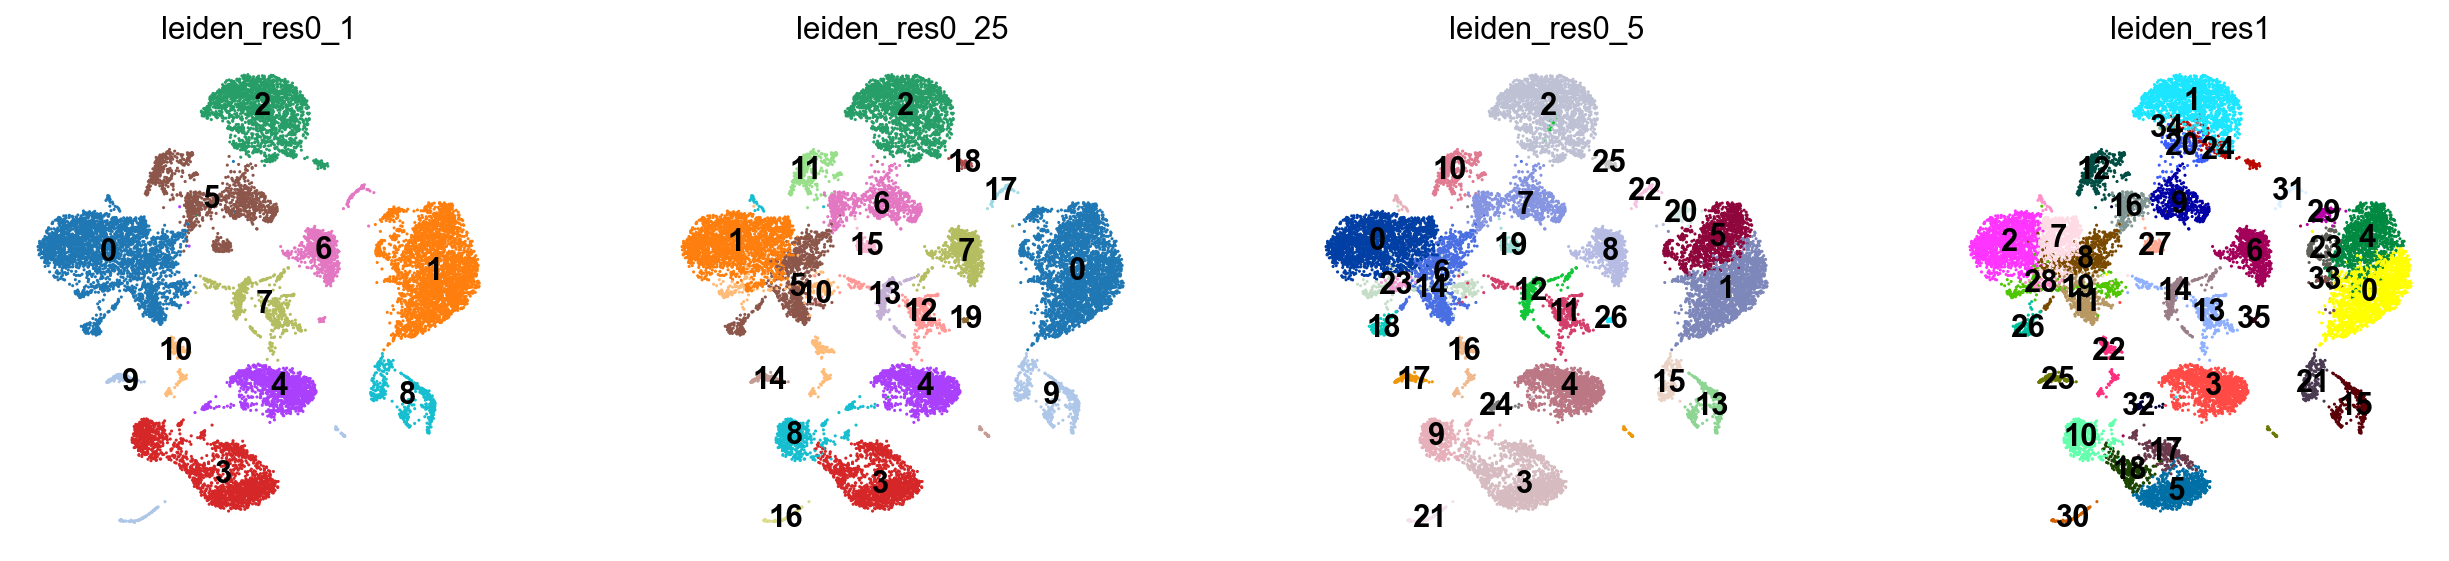

In [106]:
scanpy.pl.umap(
    misharin_filtered,
    color=["leiden_res0_1", "leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

The Leiden algorithm with a resolution of 0.1 will be used for the coarse annotation, 0.25 for the finer one.

## Coarse annotation using the method **plot_markers()**:

Macrophages


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


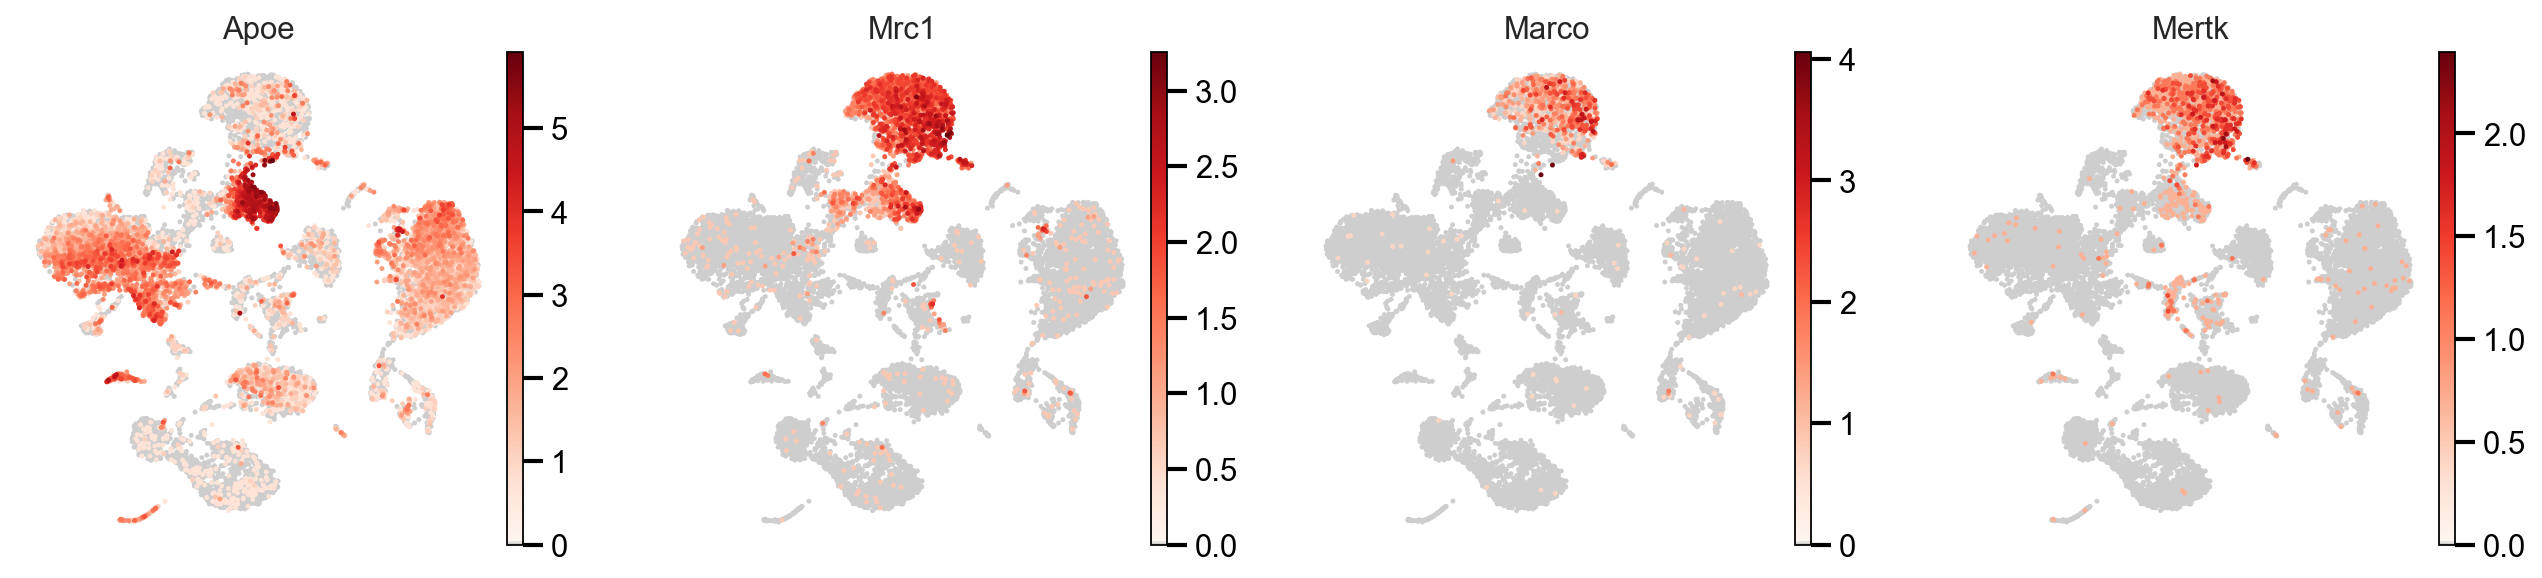

Monocytes


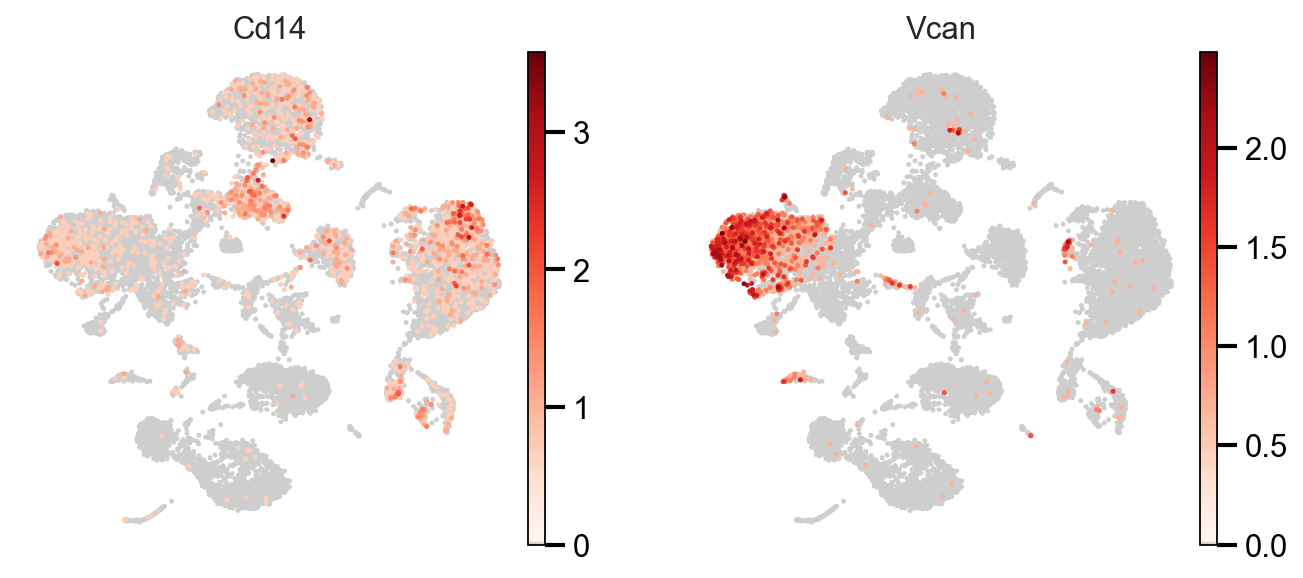

T-Cells


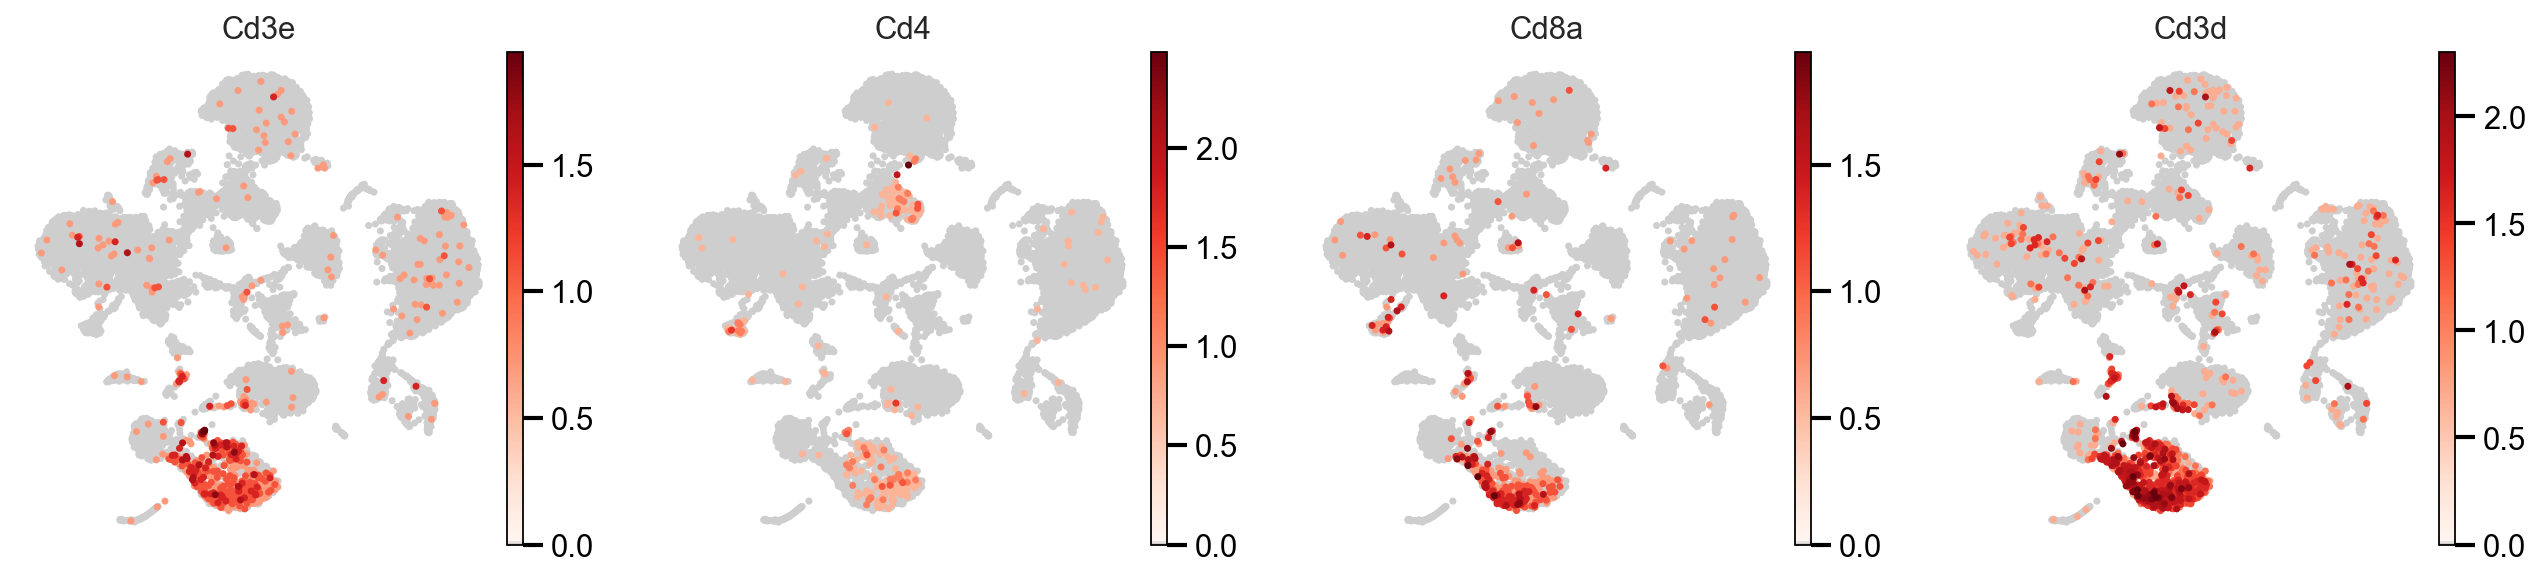

B-Cells


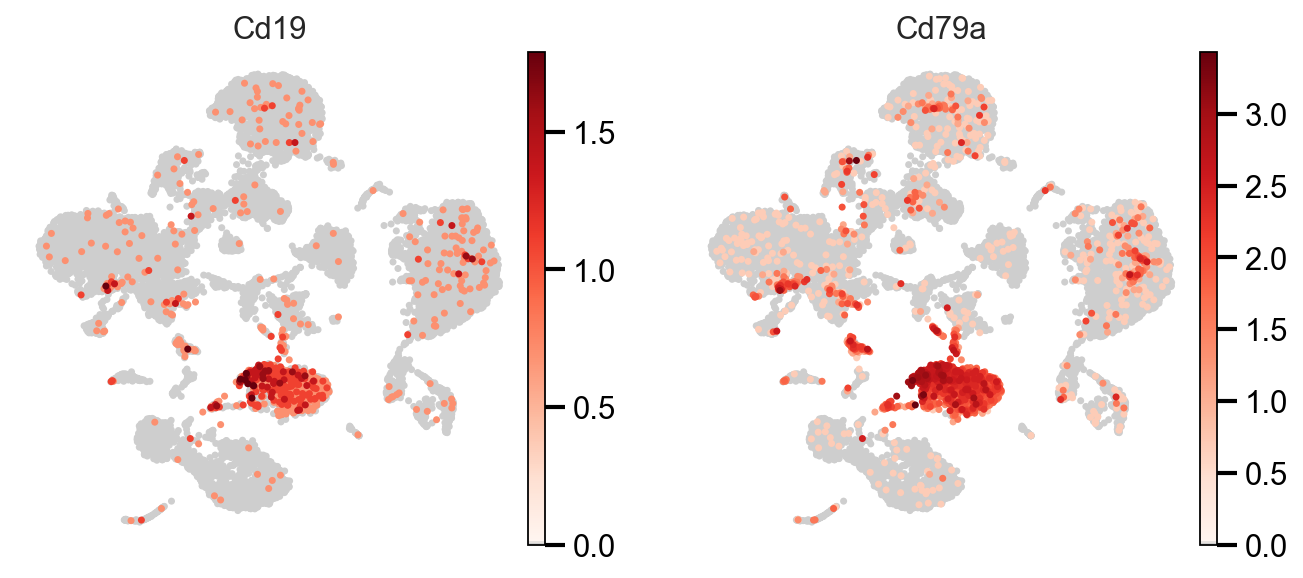

AT2


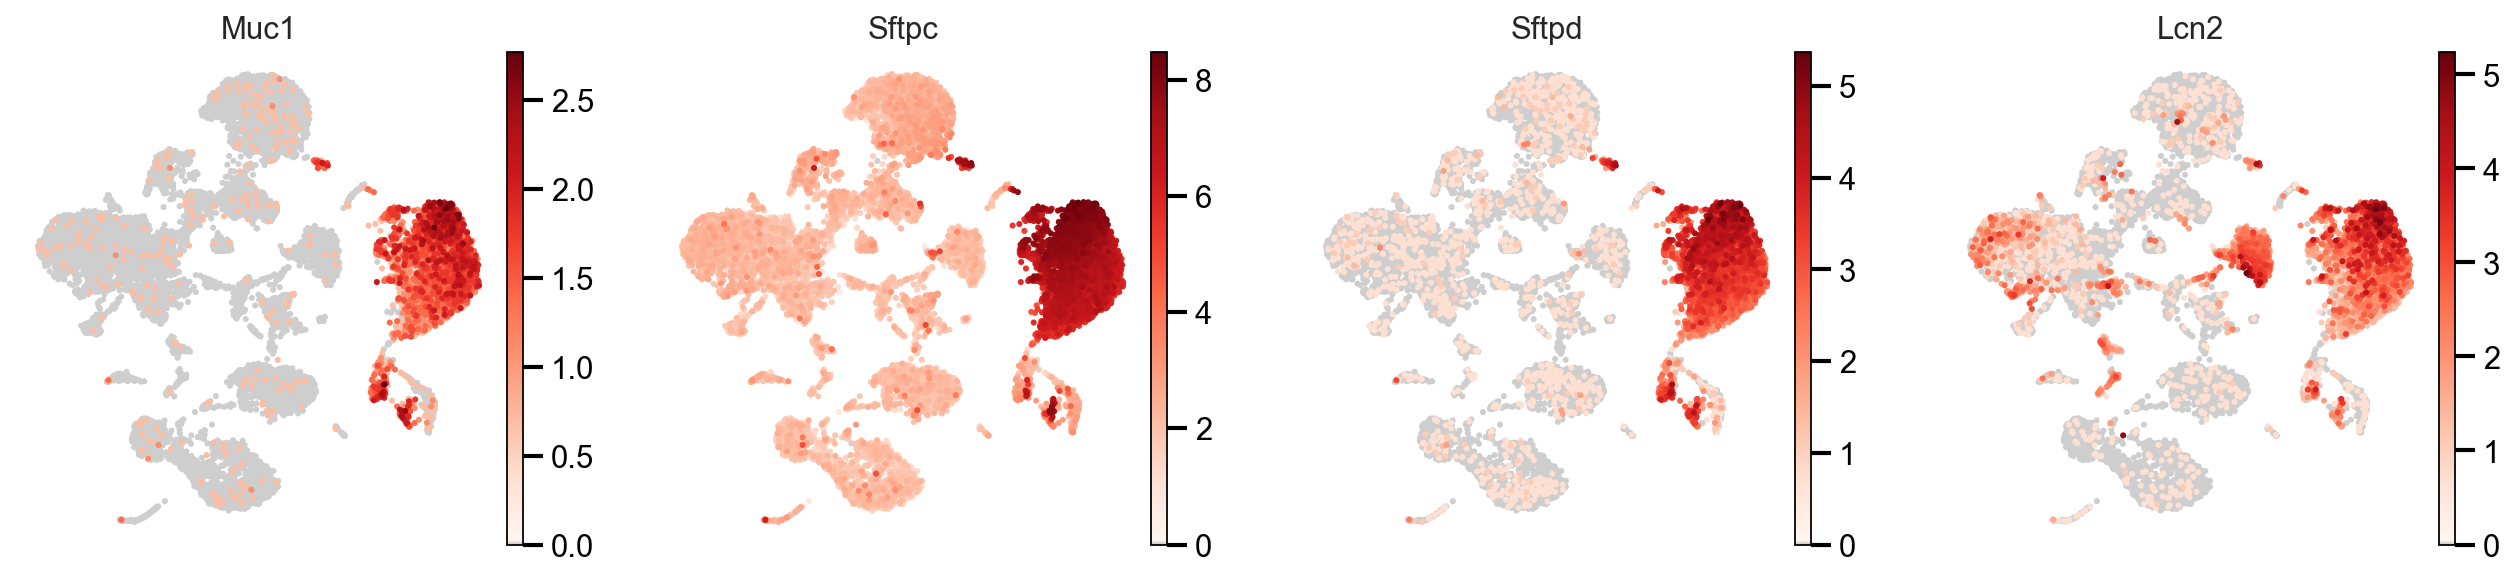

AT1


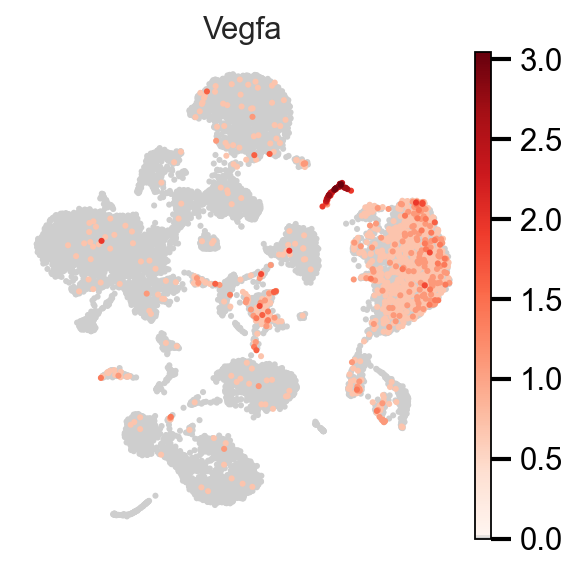

Krt8


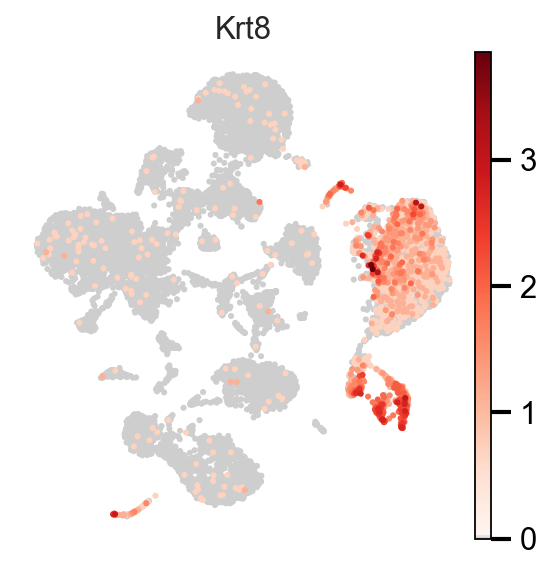

Endothelial


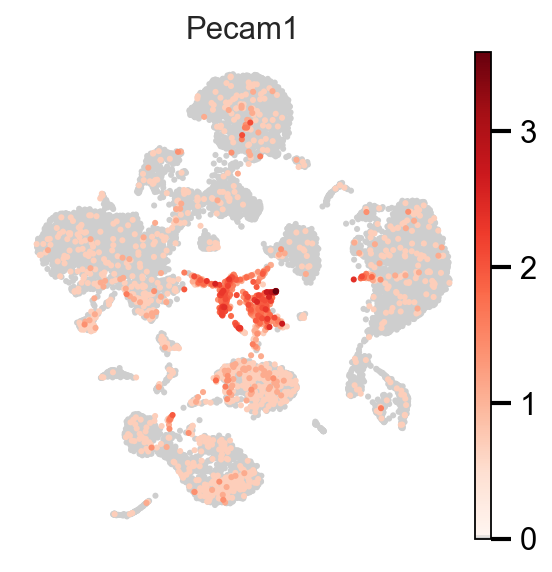

Fibroblasts


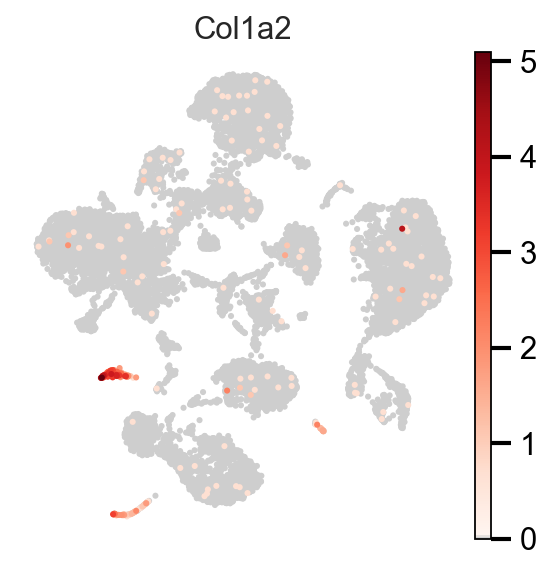

Myofibroblasts


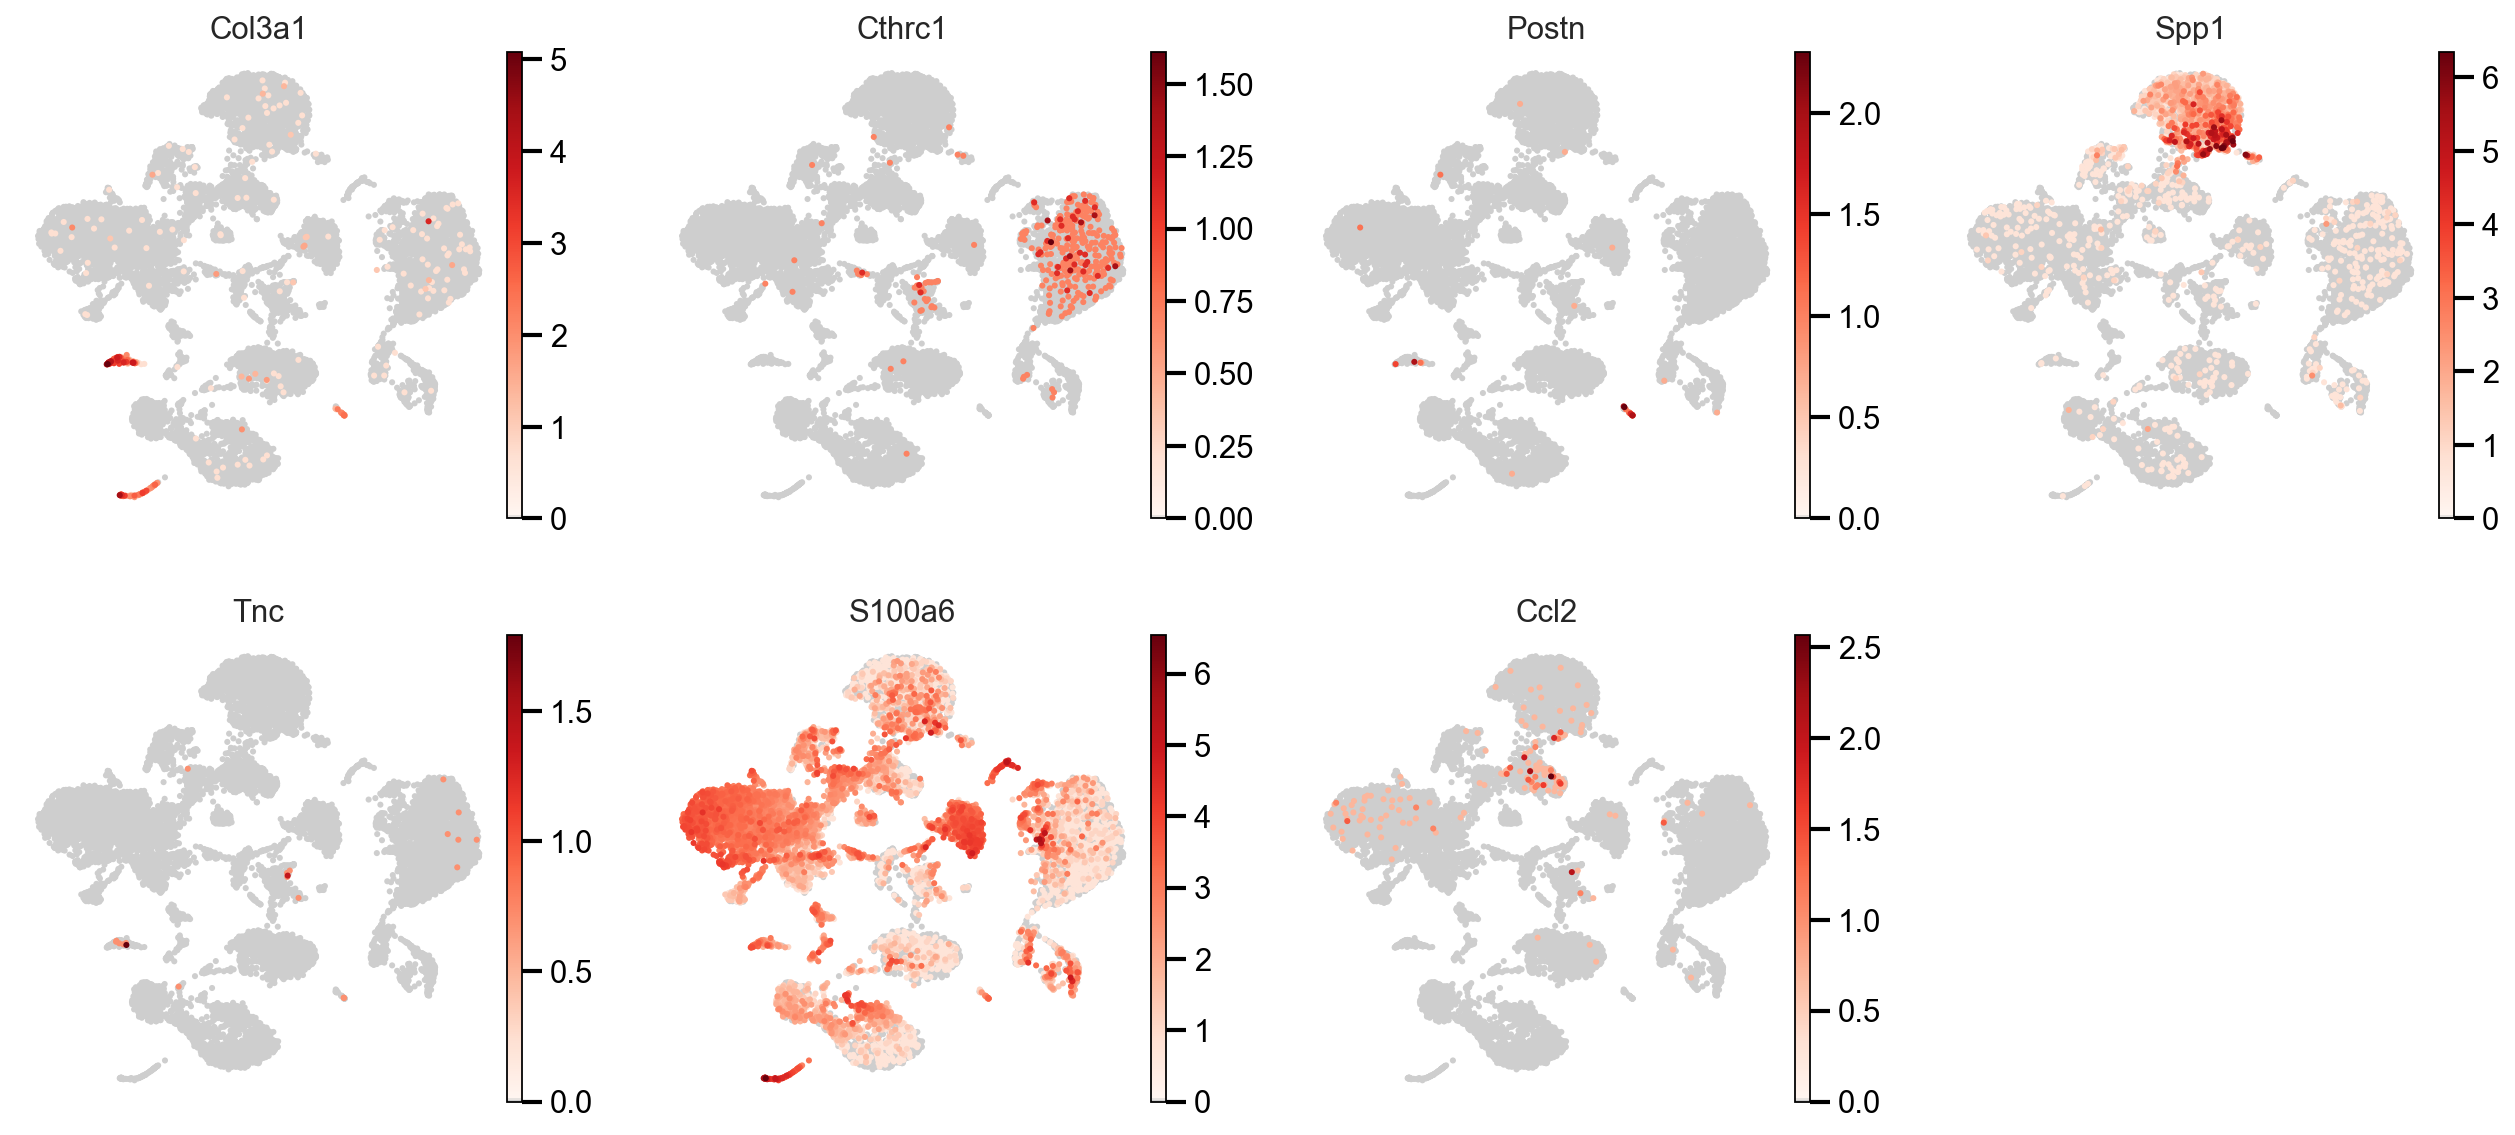

In [9]:
helper_classes_DanielStrobl.plot_markers(misharin_filtered)

In [107]:
cl_annotation_coarse = {
	"0": "Monocytes",
    "1": "AT2",
    "2": "Macrophages",
    "3": "T-cells",
    "4": "B-cells",
    "5": "Macrophages",
    "6": "AT1",   # only the small part ?
    "7": "Endothelial",
    "8": "Krt8",
    "9": "Fibroblasts",   # + Myofibroblasts ?
    "10": "10"
}

In [108]:
misharin_filtered.obs["manual_celltype_annotation_coarse"] = misharin_filtered.obs.leiden_res0_1.map(cl_annotation_coarse).astype("category")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


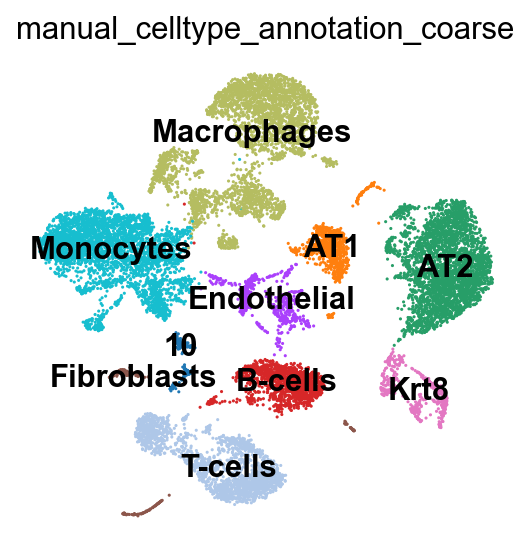

In [109]:
scanpy.pl.umap(misharin_filtered, color="manual_celltype_annotation_coarse", legend_loc="on data")

## Defining more marker genes:
Source: https://docs.google.com/spreadsheets/d/1nUMZA_I9bliJX1-x_-KRqKrF_6e229gx_l_GtOwt0rU/edit#gid=0

In [110]:
# Opening JSON file
f = open(output + 'marker_genes.json')

# returns JSON object as
# a dictionary
marker_genes = json.load(f)

# Closing file
f.close()

In [111]:
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in misharin_filtered.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

## Finer annotation using marker genes:
Marker genes mentioned in the paper only belong to macrophages and alveolar macrophages.

In [45]:
 take_a_further_look = [
    "CD4 T-cells",
    "CD8 T-cells"
]

CD4 T-CELLS:


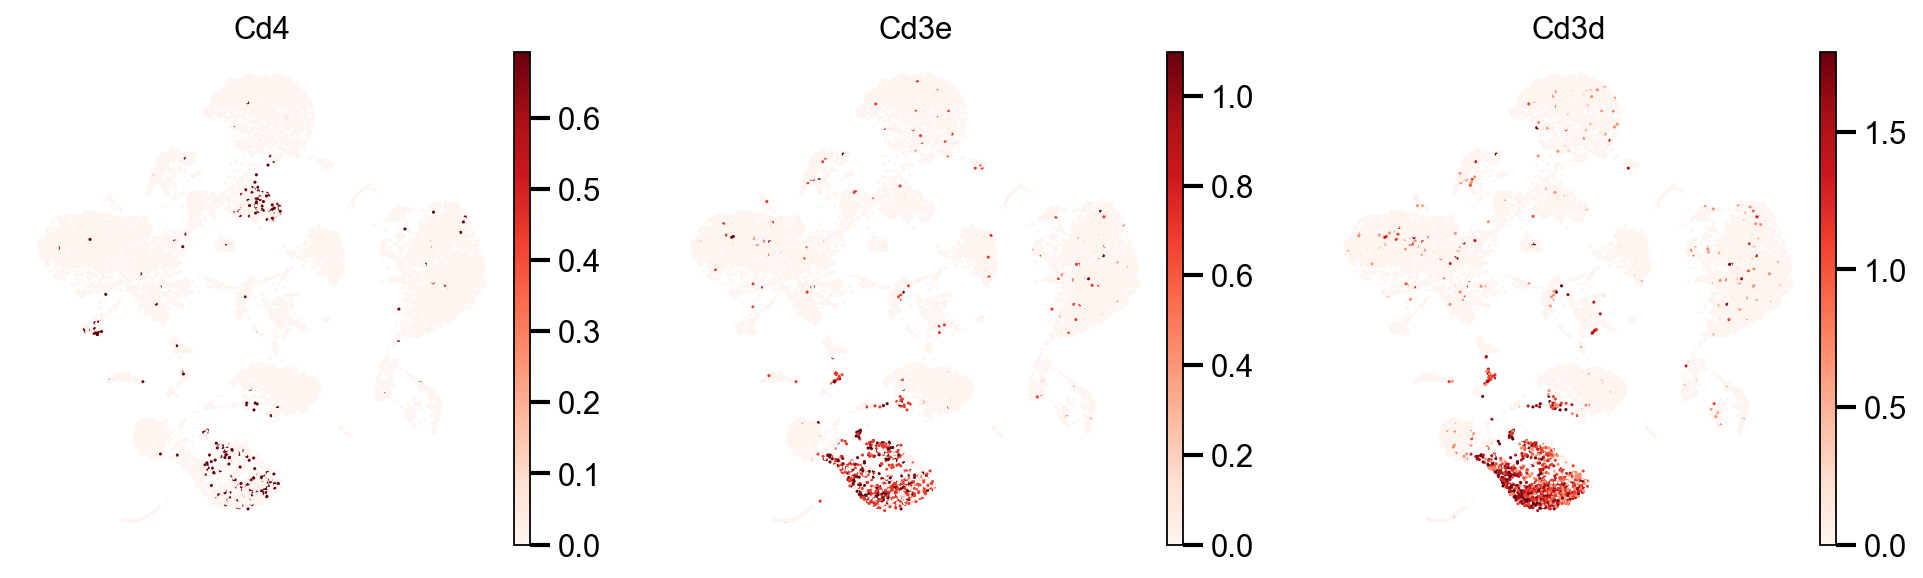





CD8 T-CELLS:


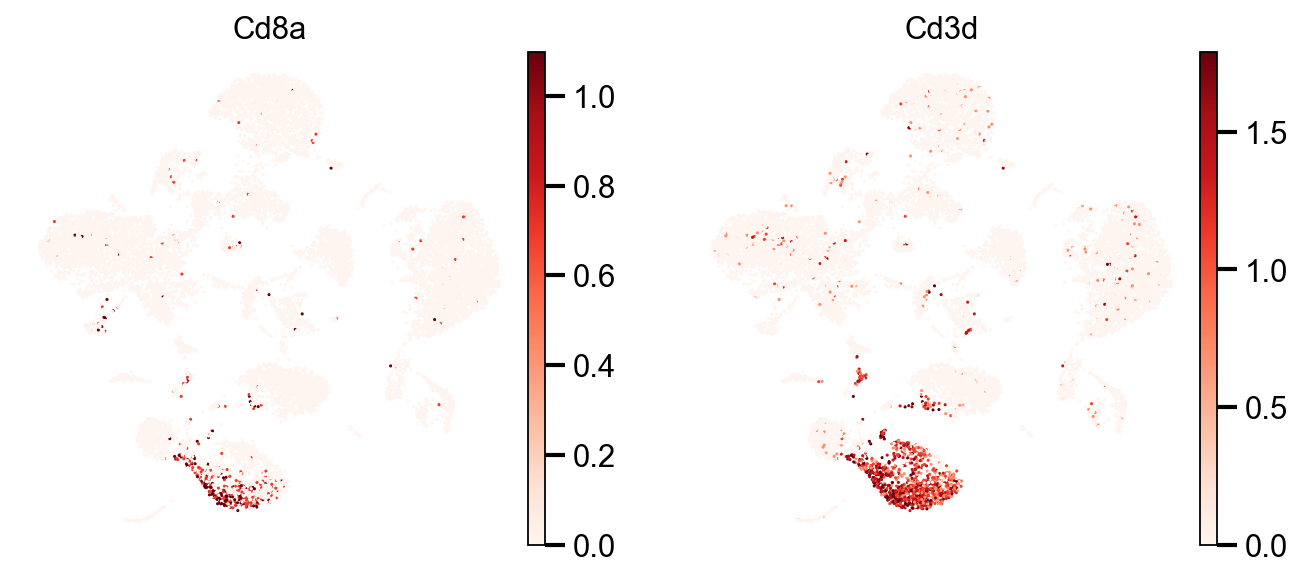

In [46]:
for ct in take_a_further_look:   #marker_genes_in_data.keys():
    print(f"{ct.upper()}:")  # print cell subtype name
    scanpy.pl.umap(
        misharin_filtered,
        color=marker_genes_in_data[ct],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    )
    print("\n\n\n")  # print white space for legibility

In [112]:
cl_annotation_fine = {
	"0": "AT2",
    "1": "Classical monocytes",
    "2": "Alveolar macrophages",
    "3": "T-cells",
    "4": "B-cells",
    "5": "Non-classical monocytes",
    "6": "Interstitial macrophages",
    "7": "Neutrophils",
    "8": "NK cells",
    "9": "Transitioning epithelial",
    "10": "Neutrophils",
    "11": "Dendritic cells",
    "12": "Endothelial",
    "13": "Aerocyte",
    "14": "Myofibroblasts",
    "15": "Dendritic cells Ccr7-hi",
    "16": "Alveolar fibroblast",
    "17": "AT1",
    "18": "Alveolar macrophages",
    "19": "19"
}

In [113]:
misharin_filtered.obs["manual_celltype_annotation_fine"] = misharin_filtered.obs.leiden_res0_25.map(
    cl_annotation_fine).astype("category")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


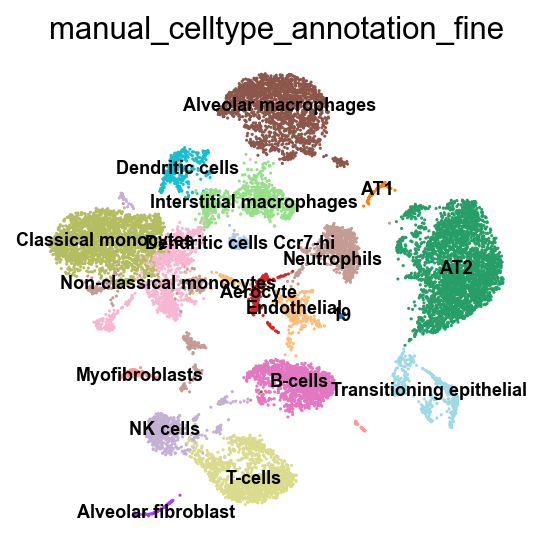

In [114]:
scanpy.pl.umap(misharin_filtered, color="manual_celltype_annotation_fine", legend_loc="on data", legend_fontsize="xx-small")

## Using differentially expressed genes to annotate the remaining clusters:

In [30]:
misharin_filtered.uns['log1p']["base"] = None

In [9]:
# coarse annotation:
scanpy.tl.rank_genes_groups(
    misharin_filtered, groupby="leiden_res0_1", method="wilcoxon", key_added="dea_leiden_0_1"
)

In [10]:
scanpy.tl.filter_rank_genes_groups(
    misharin_filtered, min_in_group_fraction=0.2, max_out_group_fraction=0.2, key="dea_leiden_0_1",
    key_added="dea_leiden_0_1_filtered",
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


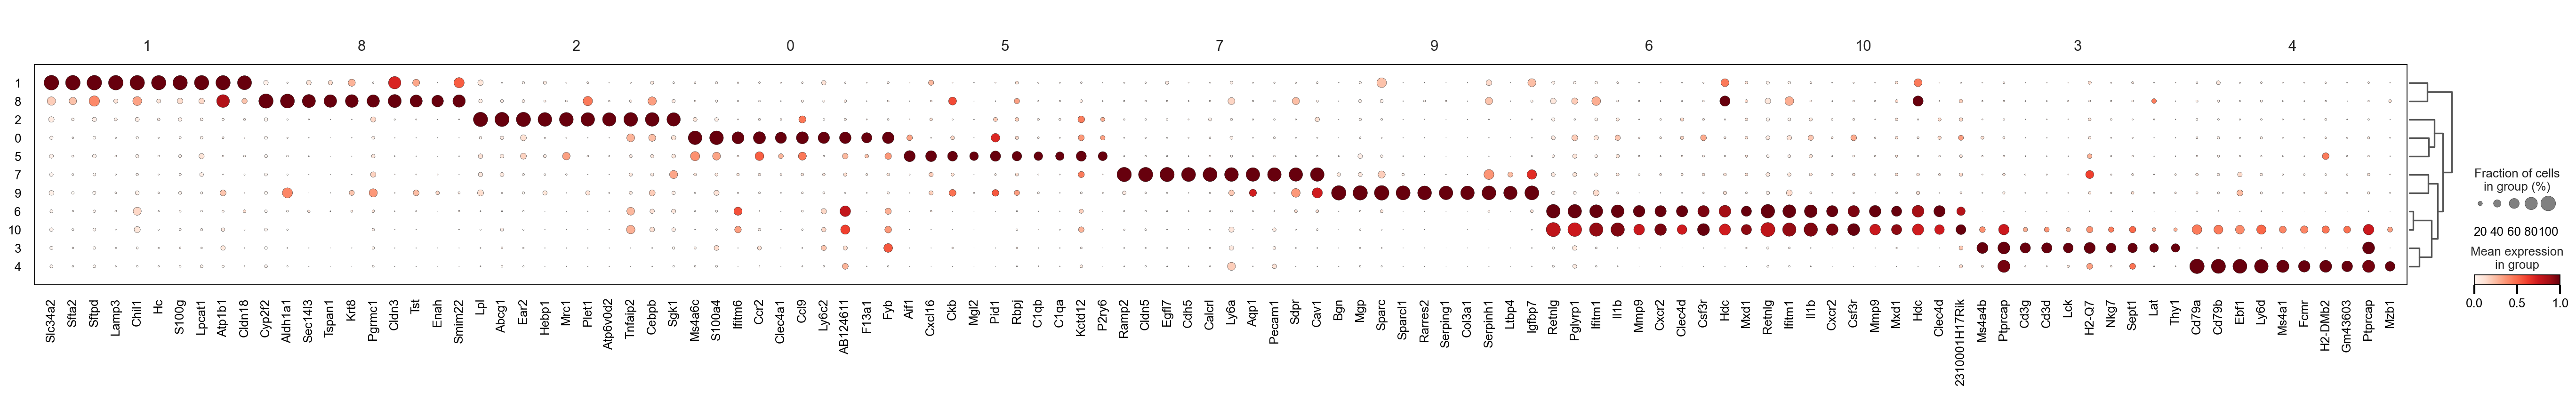

In [67]:
scanpy.pl.rank_genes_groups_dotplot(
    misharin_filtered, groupby="leiden_res0_1", standard_scale="var", n_genes=10, key="dea_leiden_0_1_filtered",
)

### Unannotated clusters - coarse annotation:
**10:**
- Retnlg, Ifitm1, Il1b, Cxcr2, Csf3r
- Conclusion: Neutrophil

In [11]:
cl_annotation_coarse = {
    "0": "Monocytes",
    "1": "AT2",
    "2": "Macrophages",
    "3": "T-cells",
    "4": "B-cells",
    "5": "Macrophages",
    "6": "AT1",  # only the small part ?
    "7": "Endothelial",
    "8": "Krt8",
    "9": "Fibroblasts",  # + Myofibroblasts ?
    "10": "Neutrophil"   # -> annotated by using differentially expressed genes
}

In [12]:
misharin_filtered.obs["manual_celltype_annotation_coarse"] = misharin_filtered.obs.leiden_res0_1.map(
    cl_annotation_coarse).astype("category")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


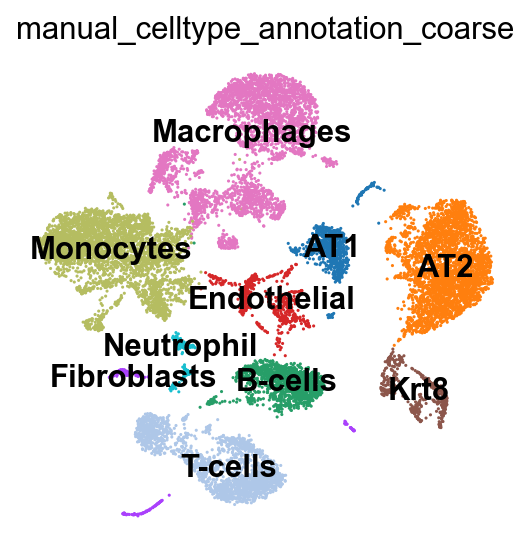

In [13]:
scanpy.pl.umap(misharin_filtered, color="manual_celltype_annotation_coarse", legend_loc="on data")

In [31]:
# fine annotation:
scanpy.tl.rank_genes_groups(
    misharin_filtered, groupby="leiden_res0_25", method="wilcoxon", key_added="dea_leiden_0_25"
)

In [32]:
scanpy.tl.filter_rank_genes_groups(
    misharin_filtered, min_in_group_fraction=0.2, max_out_group_fraction=0.2, key="dea_leiden_0_25",
    key_added="dea_leiden_0_25_filtered",
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:514: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.Colorbar(


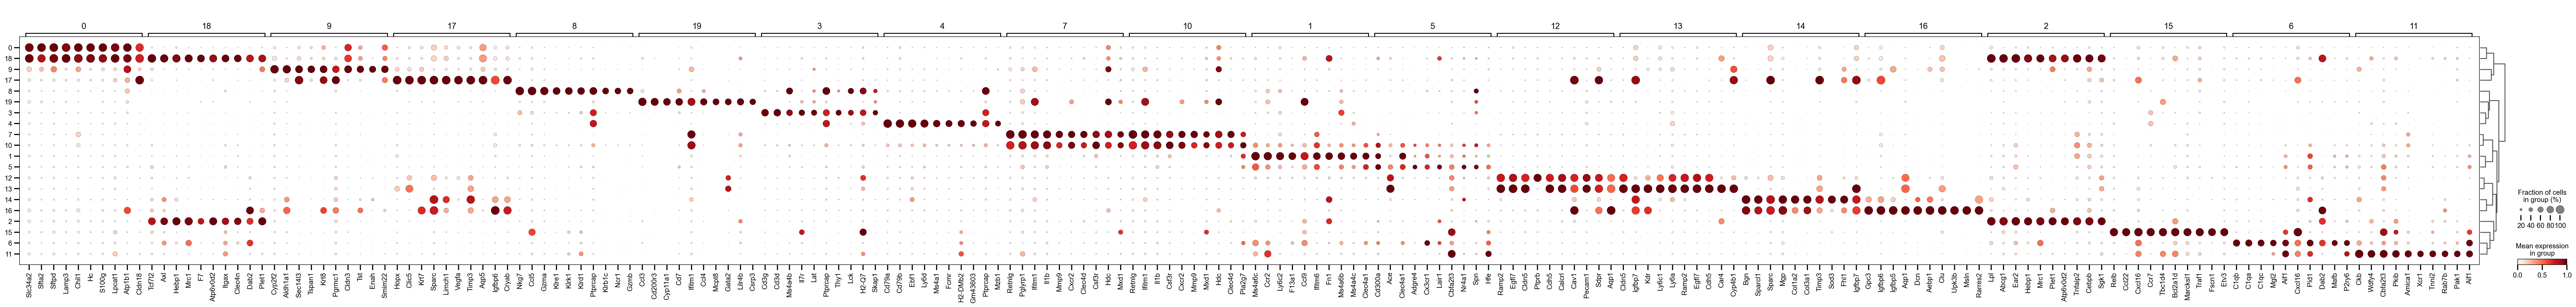

In [33]:
scanpy.pl.rank_genes_groups_dotplot(
    misharin_filtered, groupby="leiden_res0_25", standard_scale="var", n_genes=10, key="dea_leiden_0_25_filtered",
)

### Unannotated clusters - fine annotation:
**19:**
- Ccl3, Cd200r3, Cyp11a1, Cd7, Ifitm1, Ccl4, Mcpt8, Gata2, Lilr4b, Csrp3
- Conclusion: NK cells (but not clearly; alternative: macrophages)

In [115]:
cl_annotation_fine = {
	"0": "AT2",
    "1": "Classical monocytes",
    "2": "Alveolar macrophages",
    "3": "T-cells",
    "4": "B-cells",
    "5": "Non-classical monocytes",
    "6": "Interstitial macrophages",
    "7": "Neutrophils",
    "8": "NK cells",
    "9": "Transitioning epithelial",
    "10": "Neutrophils",
    "11": "Dendritic cells",
    "12": "Endothelial",
    "13": "Aerocyte",
    "14": "Myofibroblasts",
    "15": "Dendritic cells Ccr7-hi",
    "16": "Alveolar fibroblast",
    "17": "AT1",
    "18": "Alveolar macrophages",
    "19": "NK cells"   # -> annotated by using differentially expressed genes
}

In [116]:
misharin_filtered.obs["manual_celltype_annotation_fine"] = misharin_filtered.obs.leiden_res0_25.map(
    cl_annotation_fine).astype("category")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


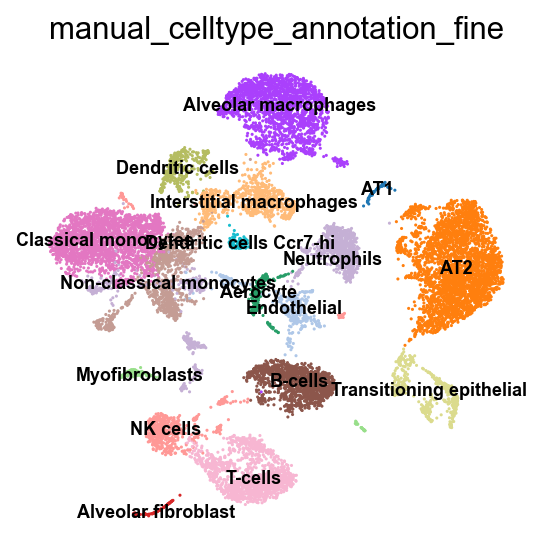

In [117]:
scanpy.pl.umap(misharin_filtered, color="manual_celltype_annotation_fine", legend_loc="on data", legend_fontsize="xx-small")

## Additional dotplot (fine annotation):

In [118]:
dotplot_markers = {
    ct: [m for m in ct_markers if m in misharin_filtered.var.index]
    for ct, ct_markers in marker_genes.items()
    if ct in marker_genes_in_data.keys()
}

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:514: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.Colorbar(


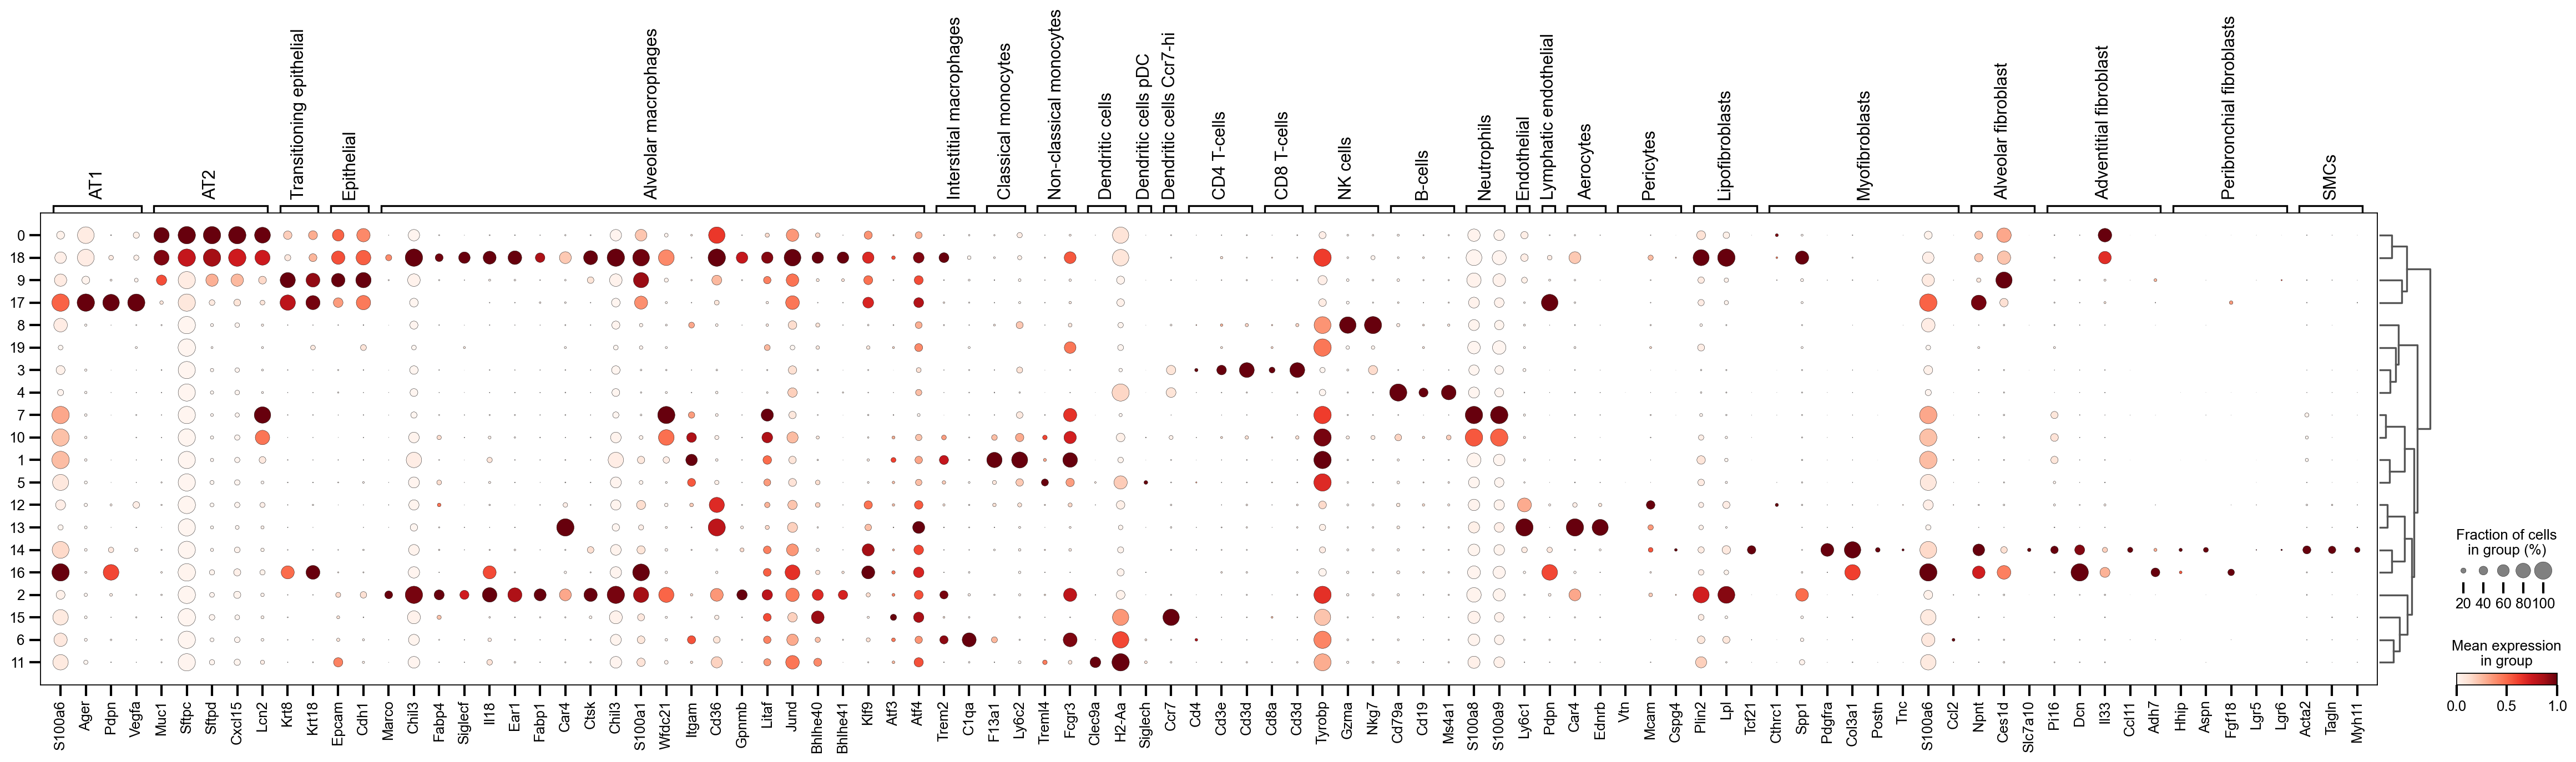

In [119]:
scanpy.pl.dotplot(
    misharin_filtered,
    groupby="leiden_res0_25",
    var_names=dotplot_markers,
    standard_scale="var",
    dendrogram=True
)

## Saving the annotated *misharin_filtered*:

In [121]:
misharin_filtered.write(output + "misharin_Emma_processed_annotated_leiden.h5ad")